**Hier werden durch die Suffix-Bäume gefundenen Teilstrukturen basierend auf AA-Sequenzen analysiert**  
Die Ergbisse können als zusätzliches Filter verwendet werden

*Beispiel für eine Teilstruktur*

In [1]:
import re
regex = re.compile('[^X]')

def filterX(S):
    uniqueChar = set(S)
    isnotX = not ("X" in uniqueChar and len(uniqueChar) == 1)
    return isnotX
    
def xRatio(S):
    isX = len(regex.sub('', S))
    return isX / len(S)

# df_sample = pd.read_csv('../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aa.gz')
# df_sample = df_sample[~df_sample.hit.isna()]
# df_sample["X_ratio"] = df_sample.hit.apply(xRatio)
# df_sample[df_sample.X_ratio > 0.8]
# df_sample = df_sample[df_sample.hit.apply(filterX)]


Definition der Hilfsfunktionen

In [2]:
import pandas as pd
from Bio import SeqIO
import os
from os import listdir
from os.path import isfile, join
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(16,8)})
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
def readPDB(path):
    for record in SeqIO.parse(path, "fasta"):
        pdb = "".join(list(record.seq))
    return pdb

In [4]:
source_dir = "../data/pdb_str/aa_hits/"
dirs = [ "".join([source_dir, f]) for f in listdir(source_dir)]
len(dirs)


999

**CATHDB Meta Information**

In [5]:
cath_meta = pd.read_csv("data/cath-b-newest-all", sep=" ", names =["pdb", "version", "cath", "range"])
cath_meta = cath_meta[["pdb", "range", "cath"]]
hier = cath_meta.cath.str.split(".", n = 4, expand = True) 
cath_meta["c"] = hier[0]
cath_meta["ca"] = hier[0].str.cat(hier[1], sep=".")
cath_meta["cat"] = cath_meta.ca.str.cat(hier[2], sep=".")
cath_meta.head()

,pdb,range,cath,c,ca,cat
0,101mA00,0-153:A,1.10.490.10,1,1.10,1.10.490
1,102lA00,1-162:A,1.10.530.40,1,1.10,1.10.530
2,102mA00,0-153:A,1.10.490.10,1,1.10,1.10.490
3,103lA00,1-162:A,1.10.530.40,1,1.10,1.10.530
4,103mA00,0-153:A,1.10.490.10,1,1.10,1.10.490


**Anzal der Proteindomänen**

In [56]:
pdbids =[ f.split(".")[0] for f in listdir("../data/pdb_str/fasta/") ]
seq = [ readPDB("../data/pdb_str/fasta/%s.fasta" % p) for p in pdbids]
cathdb = pd.DataFrame({"pdb":pdbids, "seq":seq})
cathdb = pd.merge(cath_meta, cathdb, how="inner", on="pdb")
print("Anzal der Proteindomänen zu betrachten: %s " % cathdb.shape[0])

Anzal der Proteindomänen zu betrachten: 30445 


In [57]:
cathdb.head()

,pdb,range,cath,c,ca,cat,seq
0,12asA00,4-330:A,3.30.930.10,3,3.30,3.30.930,AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLS...
1,132lA00,2-129:A,1.10.530.10,1,1.10,1.10.530,VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDG...
2,153lA00,1-185:A,1.10.530.10,1,1.10,1.10.530,RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMD...
3,155cA00,1-134:A,1.10.760.10,1,1.10,1.10.760,NEGDAAKGEKEFNKCKACHMIQAPDGTDIKGGKTGPNLYGVVGRKI...
4,16pkA02,199-406:A,3.40.50.1260,3,3.40,3.40.50,YFAKVLGNPPRPLVAIVGGAKVSDKIQLLDNMLQRIDYLLIGGAMA...


**Anzahl der Proteindomänen auf C-Level in CATH-Hierarchie**

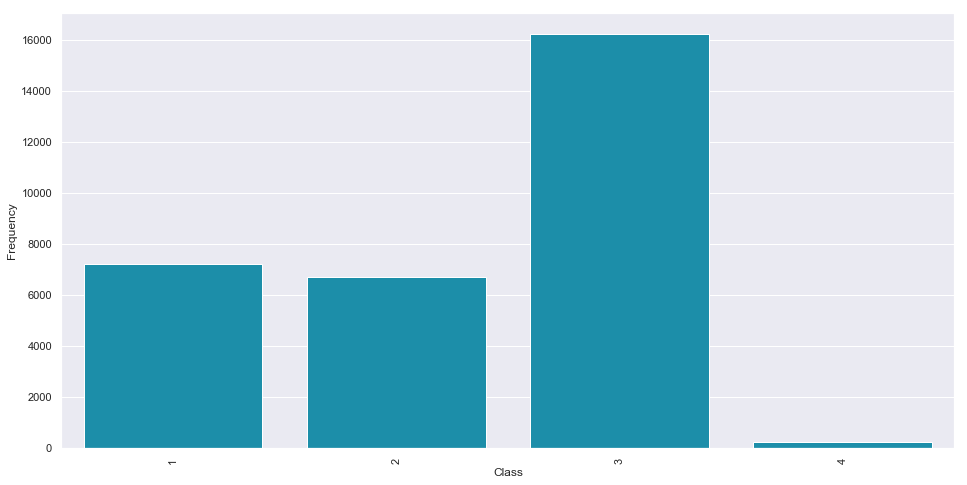

In [10]:
ca_N = cathdb.groupby(["c"]).size().reset_index(name="N")
fig, ax = plt.subplots()
fig = sns.barplot(ca_N.c, ca_N.N, ax=ax, color="#059DC0")
_ = ax.set(xlabel='Class', ylabel='Frequency', title="")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**Anzahl der Proteindomänen auf CA-Level in CATH-Hierarchie**

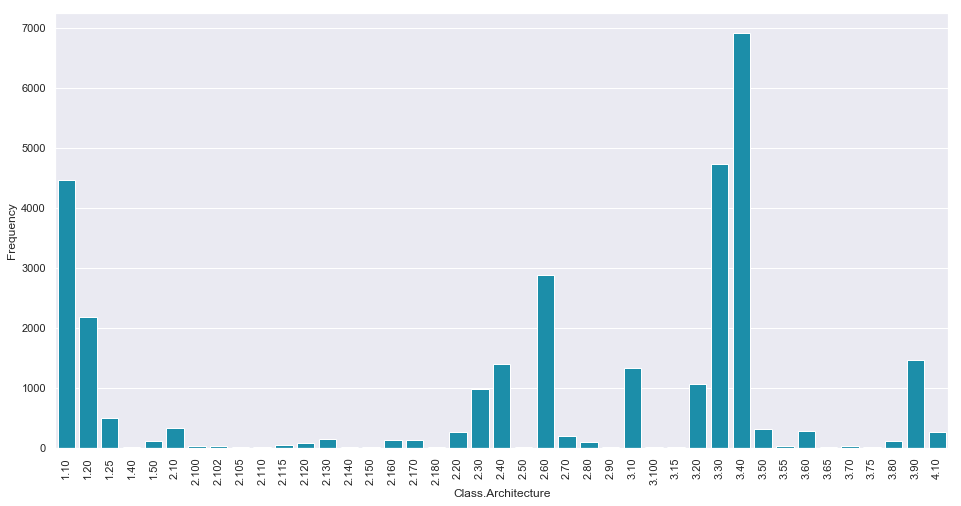

In [11]:
ca_N = cathdb.groupby(["ca"]).size().reset_index(name="N")
fig, ax = plt.subplots()
fig = sns.barplot(ca_N.ca, ca_N.N, ax=ax, color="#059DC0")
_ = ax.set(xlabel='Class.Architecture', ylabel='Frequency', title="")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**Histogramm der Längen der durch Suffix-Bäume ermittelten Teilstrukturen**

In [25]:
def clean(_df):
    _df = _df[~_df.hit.isna()]
    _df["X_ratio"] = _df.hit.apply(xRatio)
    return _df[_df.X_ratio <= 0.6]

def read(i):
    f = dirs[i]
    print(i, f)
    return pd.read_csv(f)

group = lambda _df: _df.groupby(["hit", "hit_length", "X_ratio"]).size().reset_index(name="N")

df = pd.concat([ group(clean(read(i))) for i in range(0, len(dirs))] )
df = df.groupby(["hit", "hit_length"])["N"].agg('sum').reset_index(name="N")

df.to_csv("hit_aa_statistic.csv", index=False)
# df = pd.read_csv("hit_aa_statistic.csv")

0 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aa.gz


C:\Users\tomin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ab.gz
2 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ac.gz
3 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ad.gz
4 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ae.gz
5 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_af.gz
6 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ag.gz
7 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ah.gz
8 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ai.gz
9 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aj.gz
10 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ak.gz
11 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_al.gz
12 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_am.gz
13 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_an.gz
14 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ao.gz
15 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ap.gz
16 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aq.gz
17 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ar.gz
18 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_as.gz
19 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_at.gz
20

155 ../data/pdb_str/aa_hits/hits_xaf_cath_pairs_az.gz
156 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aa.gz
157 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ab.gz
158 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ac.gz
159 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ad.gz
160 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ae.gz
161 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_af.gz
162 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ag.gz
163 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ah.gz
164 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ai.gz
165 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aj.gz
166 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ak.gz
167 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_al.gz
168 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_am.gz
169 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_an.gz
170 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ao.gz
171 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ap.gz
172 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aq.gz
173 ../data/pdb_str/aa_hits/

307 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_av.gz
308 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_aw.gz
309 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_ax.gz
310 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_ay.gz
311 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_az.gz
312 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_aa.gz
313 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ab.gz
314 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ac.gz
315 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ad.gz
316 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ae.gz
317 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_af.gz
318 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ag.gz
319 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ah.gz
320 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ai.gz
321 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_aj.gz
322 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ak.gz
323 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_al.gz
324 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_am.gz
325 ../data/pdb_str/aa_hits/

459 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ar.gz
460 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_as.gz
461 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_at.gz
462 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_au.gz
463 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_av.gz
464 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_aw.gz
465 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ax.gz
466 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ay.gz
467 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_az.gz
468 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_aa.gz
469 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ab.gz
470 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ac.gz
471 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ad.gz
472 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ae.gz
473 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_af.gz
474 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ag.gz
475 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ah.gz
476 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ai.gz
477 ../data/pdb_str/aa_hits/

611 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_an.gz
612 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ao.gz
613 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ap.gz
614 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_aq.gz
615 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ar.gz
616 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_as.gz
617 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_at.gz
618 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_au.gz
619 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_av.gz
620 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_aw.gz
621 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ax.gz
622 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ay.gz
623 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_az.gz
624 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_aa.gz
625 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ab.gz
626 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ac.gz
627 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ad.gz
628 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ae.gz
629 ../data/pdb_str/aa_hits/

763 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aj.gz
764 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ak.gz
765 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_al.gz
766 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_am.gz
767 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_an.gz
768 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ao.gz
769 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ap.gz
770 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aq.gz
771 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ar.gz
772 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_as.gz
773 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_at.gz
774 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_au.gz
775 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_av.gz
776 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aw.gz
777 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ax.gz
778 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ay.gz
779 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_az.gz
780 ../data/pdb_str/aa_hits/hits_xbe_cath_pairs_aa.gz
781 ../data/pdb_str/aa_hits/

915 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_af.gz
916 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ag.gz
917 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ah.gz
918 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ai.gz
919 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aj.gz
920 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ak.gz
921 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_al.gz
922 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_am.gz
923 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_an.gz
924 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ao.gz
925 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ap.gz
926 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aq.gz
927 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ar.gz
928 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_as.gz
929 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_at.gz
930 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_au.gz
931 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_av.gz
932 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aw.gz
933 ../data/pdb_str/aa_hits/

In [5]:
def clean(_df):
    _df = _df[~_df.hit.isna()]
    _df["X_ratio"] = _df.hit.apply(xRatio)
    _df = _df[_df.X_ratio <= 0.6]
    _df = _df[_df.hit_length > 5]
    return _df

def read(i):
    f = dirs[i]
    print(i, f)
    return pd.read_csv(f)

group = lambda _df: _df.groupby(["hit", "hit_length", "X_ratio"]).size().reset_index(name="N")

df = pd.concat([ clean(read(i)) for i in range(0,  len(dirs)) ])
# df = df.groupby(["hit", "hit_length"])["N"].agg('sum').reset_index(name="N")

df.to_csv("hit_aa_sample.csv", index=False)
# df = pd.read_csv("hit_aa_statistic.csv")

0 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aa.gz


C:\Users\tomin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ab.gz
2 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ac.gz
3 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ad.gz
4 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ae.gz
5 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_af.gz
6 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ag.gz
7 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ah.gz
8 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ai.gz
9 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aj.gz
10 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ak.gz
11 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_al.gz
12 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_am.gz
13 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_an.gz
14 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ao.gz
15 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ap.gz
16 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_aq.gz
17 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_ar.gz
18 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_as.gz
19 ../data/pdb_str/aa_hits/hits_xaa_cath_pairs_at.gz
20

155 ../data/pdb_str/aa_hits/hits_xaf_cath_pairs_az.gz
156 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aa.gz
157 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ab.gz
158 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ac.gz
159 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ad.gz
160 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ae.gz
161 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_af.gz
162 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ag.gz
163 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ah.gz
164 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ai.gz
165 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aj.gz
166 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ak.gz
167 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_al.gz
168 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_am.gz
169 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_an.gz
170 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ao.gz
171 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_ap.gz
172 ../data/pdb_str/aa_hits/hits_xag_cath_pairs_aq.gz
173 ../data/pdb_str/aa_hits/

307 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_av.gz
308 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_aw.gz
309 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_ax.gz
310 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_ay.gz
311 ../data/pdb_str/aa_hits/hits_xal_cath_pairs_az.gz
312 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_aa.gz
313 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ab.gz
314 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ac.gz
315 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ad.gz
316 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ae.gz
317 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_af.gz
318 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ag.gz
319 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ah.gz
320 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ai.gz
321 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_aj.gz
322 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_ak.gz
323 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_al.gz
324 ../data/pdb_str/aa_hits/hits_xam_cath_pairs_am.gz
325 ../data/pdb_str/aa_hits/

459 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ar.gz
460 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_as.gz
461 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_at.gz
462 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_au.gz
463 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_av.gz
464 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_aw.gz
465 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ax.gz
466 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_ay.gz
467 ../data/pdb_str/aa_hits/hits_xar_cath_pairs_az.gz
468 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_aa.gz
469 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ab.gz
470 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ac.gz
471 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ad.gz
472 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ae.gz
473 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_af.gz
474 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ag.gz
475 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ah.gz
476 ../data/pdb_str/aa_hits/hits_xas_cath_pairs_ai.gz
477 ../data/pdb_str/aa_hits/

611 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_an.gz
612 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ao.gz
613 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ap.gz
614 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_aq.gz
615 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ar.gz
616 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_as.gz
617 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_at.gz
618 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_au.gz
619 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_av.gz
620 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_aw.gz
621 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ax.gz
622 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_ay.gz
623 ../data/pdb_str/aa_hits/hits_xax_cath_pairs_az.gz
624 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_aa.gz
625 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ab.gz
626 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ac.gz
627 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ad.gz
628 ../data/pdb_str/aa_hits/hits_xay_cath_pairs_ae.gz
629 ../data/pdb_str/aa_hits/

763 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aj.gz
764 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ak.gz
765 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_al.gz
766 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_am.gz
767 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_an.gz
768 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ao.gz
769 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ap.gz
770 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aq.gz
771 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ar.gz
772 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_as.gz
773 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_at.gz
774 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_au.gz
775 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_av.gz
776 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_aw.gz
777 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ax.gz
778 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_ay.gz
779 ../data/pdb_str/aa_hits/hits_xbd_cath_pairs_az.gz
780 ../data/pdb_str/aa_hits/hits_xbe_cath_pairs_aa.gz
781 ../data/pdb_str/aa_hits/

915 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_af.gz
916 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ag.gz
917 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ah.gz
918 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ai.gz
919 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aj.gz
920 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ak.gz
921 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_al.gz
922 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_am.gz
923 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_an.gz
924 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ao.gz
925 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ap.gz
926 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aq.gz
927 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_ar.gz
928 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_as.gz
929 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_at.gz
930 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_au.gz
931 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_av.gz
932 ../data/pdb_str/aa_hits/hits_xbj_cath_pairs_aw.gz
933 ../data/pdb_str/aa_hits/

In [7]:
# df.to_csv("hit_aa_sample.csv", index=False)
df.shape

(290786, 5)

In [62]:
df = pd.read_csv("hit_aa_sample.csv")
df = pd.merge(df, cathdb[["pdb", "seq"]], left_on="x", right_on="pdb")
df = pd.merge(df, cathdb[["pdb", "seq"]], left_on="y", right_on="pdb")
df.drop(columns=["X_ratio", "pdb_x", "pdb_y"]).to_csv("hit_aa_sample.csv", index=False)

Man sieht das die Teilstrukturen der Länge=1 weniger vorkommen als der Länge>1. Der Grund ist, dass ich nur die längsten Teilstrukturen behalte und den Rest verwerfe. 

In [49]:
df_N.head(30)

,hit_length,N
0,1,213081
1,2,191900363
2,3,425241107
3,4,50181912
4,5,3369474
5,6,234907
6,7,49703
7,8,5366
8,9,540
9,10,71


**Das Histogramm für alle Teilstrukturen ist noch etwas unübersichtlich**

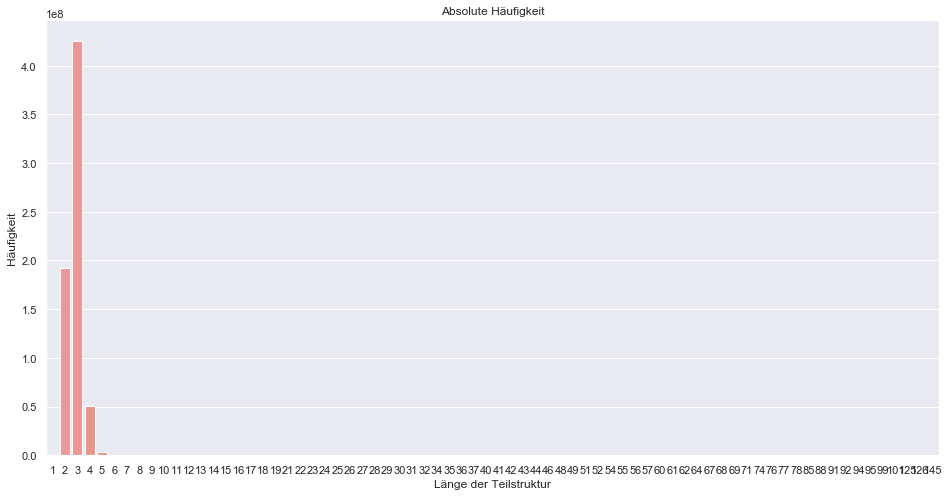

In [35]:
fig, ax = plt.subplots()
fig=sns.barplot(df_N.hit_length, df_N.N, ax=ax)
_ = ax.set(xlabel='Länge der Teilstruktur', ylabel='Häufigkeit', title="Absolute Häufigkeit")

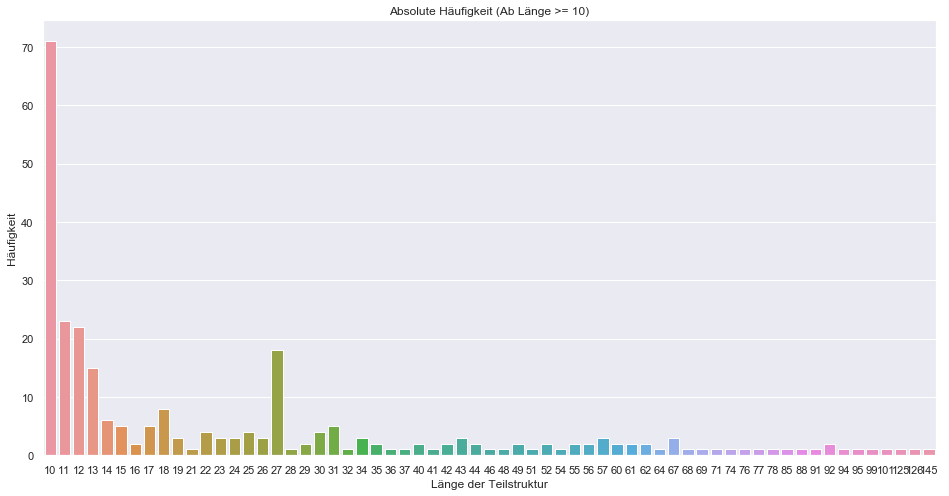

In [36]:
_df_N = df_N[df_N.hit_length >= 10]
fig, ax = plt.subplots()
fig=sns.barplot(_df_N.hit_length, _df_N.N, ax=ax)
_ = ax.set(xlabel='Länge der Teilstruktur', ylabel='Häufigkeit', title="Absolute Häufigkeit (Ab Länge >= 10)")

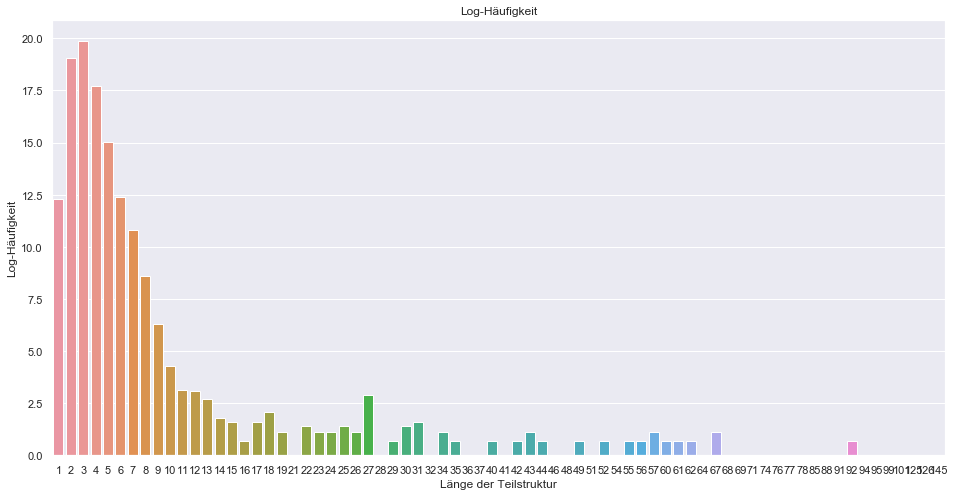

In [37]:
fig, ax = plt.subplots()
fig=sns.barplot(df_N.hit_length, np.log(df_N.N))
_ = ax.set(xlabel='Länge der Teilstruktur', ylabel='Log-Häufigkeit', title="Log-Häufigkeit")

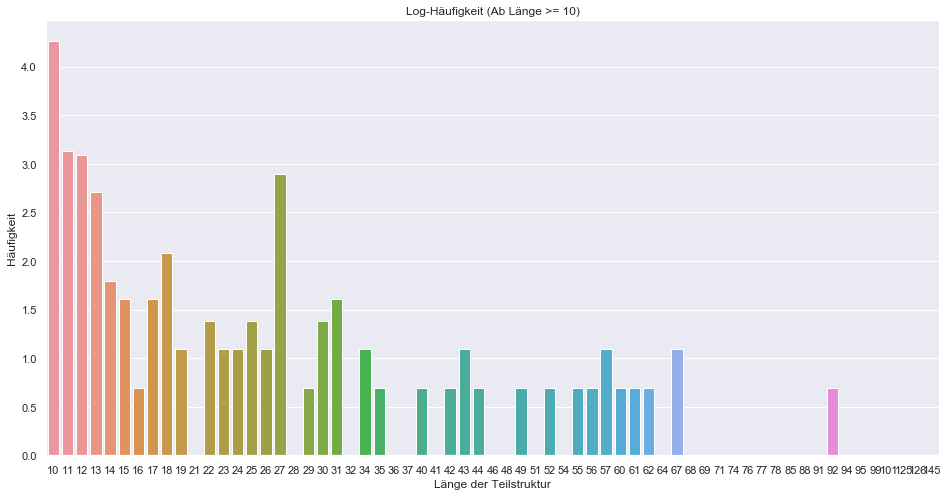

In [38]:
_df_N = df_N[df_N.hit_length >= 10]
fig, ax = plt.subplots()
fig=sns.barplot(_df_N.hit_length, np.log(_df_N.N), ax=ax)
_ = ax.set(xlabel='Länge der Teilstruktur', ylabel='Häufigkeit', title="Log-Häufigkeit (Ab Länge >= 10)")